### Training and restoration of simulated nanoparticles in a supervised way

*This notebook presents the training of a supervised model and the restoration of simulated nanoparticles data with simulated degradation from a degraded acquisition. The data set consists of 600 2D images from simulated nanoparticles. The nanoparticles were already forward projected using tomosipo's Radon transform (0°:1°:180°), and reconstructed with limited number of projections in three scenarios using SIRT algorithm to mimic scenario from possibly real experimental acquisitions of nanoparticles :*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

*The DL model is trained to restore the SIRT reconstruction suffering from several reconstruction artefacts. The goal is to then apply the train model for the restoration of a real data set with similar nanoparticles. The model is applied on 2D images only.*

In [10]:
import sys
sys.path.insert(0, '../../Src')
from model import *
from radon import *
from dip import *
from utils import *

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imsave
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

dtype = torch.cuda.FloatTensor

plt.gray()

<Figure size 640x480 with 0 Axes>

#### Load the simulated data (500 for train, 50 for test and 50 for validation) and create the data loaders.

*Data/Simulated contains reference SIRT reconstructions (simu_full.tif) and SIRT reconstructions for the three mentionned scenarios (simu_mw60s2/mw60s10/mw30s2). The datasets are splitted between train, test and validation data.*

Acquisition case can be changed with the **ACQUISITION_CASE** parameter.

In [4]:
reference = imread('../../Data/Simulated_8b/simu_full.tif')

# 1, 2 or 3 corresponding to acquisition range -60:2:+60, -60:10:+60 and -30:2:+30 respectively
ACQUISITION_CASE = 3
paths = {
    1: "../../Data/Simulated_8b/simu_mw60s2.tif",
    2: "../../Data/Simulated_8b/simu_mw60s10.tif",
    3: "../../Data/Simulated_8b/simu_mw30s2.tif",
}

degraded = imread(paths[ACQUISITION_CASE])

degraded = rearrange(torch.from_numpy(degraded).type(dtype), 'n x y -> n 1 x y')
reference = rearrange(torch.from_numpy(reference).type(dtype), 'n x y -> n 1 x y')

ref_train, ref_valid, ref_test = reference[:500], reference[500:550], reference[550:]
deg_train, deg_valid, deg_test = degraded[:500], degraded[500:550], degraded[550:]

In [ ]:
class myDataset(Dataset):
    def __init__(self, degraded_data, gt_data):
        self.degraded_data = degraded_data
        self.gt_data = gt_data

    def __len__(self):
        return self.degraded_data.shape[0]

    def __getitem__(self, idx):
        input_data = self.degraded_data[idx,:,:]
        ref_data = self.gt_data[idx,:,:]
        
        return input_data, ref_data

# Creation of the different data loaders
train_dataset = myDataset(deg_train, ref_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

valid_dataset = myDataset(deg_valid, ref_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=True)

test_dataset = myDataset(deg_test, ref_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#### Setup of the network, training parameters and training loop

*Training parameter (epochs, learning rate) are set with the same values as the article. The U-Net model is setup as described in the article. The mixed L1-MSSSIM loss is used for the training. The network is trained with the 500 train images and uses 50 images for validation during training. The train and validation losses are computed and displayed after training.*

In [12]:
EPOCHS = 30
LR = 3e-4

ud_filters, skip_filters = [32,64,128], [8,16,32]
n_scale = len(ud_filters)
model = model_unet(input_shape=1,
            down_filters=ud_filters, up_filters=ud_filters, skip_filters=skip_filters,
            down_kernels=[3]*len(ud_filters), up_kernels=[3]*len(ud_filters), skip_kernels=[1]*len(ud_filters),
            up_mode='bilinear', down_mode='stride', pad_mode='reflect'
           ).to('cuda').type(dtype)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [13]:
global_train_loss = []
global_val_loss = []

for epoch in range(EPOCHS):

    model.train()

    epoch_loss = []
    
    loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for train_data, gt_train_data in loop:

        for param in model.parameters():
            param.grad = None

        out = model(train_data)

        loss = l1_mssim_loss(out, gt_train_data)

        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())

    global_train_loss.append(np.mean(epoch_loss))

    model.eval()
    val_epoch_loss = []
    with torch.no_grad():
        for val_data, gt_val_data in valid_dataloader:
            val_out = model(val_data)
            val_loss = l1_mssim_loss(val_out, gt_val_data)
            val_epoch_loss.append(val_loss.item())
        global_val_loss.append(np.mean(val_epoch_loss))

    print(f'Training loss {global_train_loss[-1]:.3f} - Validation loss {global_val_loss[-1]:.3f}')

Epoch 1/30: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]


Training loss 1.950 - Validation loss 1.892


Epoch 2/30: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]


Training loss 1.766 - Validation loss 1.716


Epoch 3/30: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]


Training loss 1.563 - Validation loss 1.457


Epoch 4/30: 100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


Training loss 1.403 - Validation loss 1.393


Epoch 5/30: 100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


Training loss 1.253 - Validation loss 1.185


Epoch 6/30: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]


Training loss 1.120 - Validation loss 1.089


Epoch 7/30: 100%|██████████| 125/125 [00:16<00:00,  7.70it/s]


Training loss 1.001 - Validation loss 0.921


Epoch 8/30: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]


Training loss 0.879 - Validation loss 0.837


Epoch 9/30: 100%|██████████| 125/125 [00:16<00:00,  7.69it/s]


Training loss 0.775 - Validation loss 0.719


Epoch 10/30: 100%|██████████| 125/125 [00:16<00:00,  7.64it/s]


Training loss 0.683 - Validation loss 0.626


Epoch 11/30: 100%|██████████| 125/125 [00:17<00:00,  7.13it/s]


Training loss 0.616 - Validation loss 0.643


Epoch 12/30: 100%|██████████| 125/125 [00:16<00:00,  7.64it/s]


Training loss 0.581 - Validation loss 0.603


Epoch 13/30: 100%|██████████| 125/125 [00:16<00:00,  7.73it/s]


Training loss 0.558 - Validation loss 0.568


Epoch 14/30: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]


Training loss 0.550 - Validation loss 0.580


Epoch 15/30: 100%|██████████| 125/125 [00:16<00:00,  7.71it/s]


Training loss 0.551 - Validation loss 0.589


Epoch 16/30: 100%|██████████| 125/125 [00:16<00:00,  7.70it/s]


Training loss 0.547 - Validation loss 0.561


Epoch 17/30: 100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


Training loss 0.544 - Validation loss 0.571


Epoch 18/30: 100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Training loss 0.536 - Validation loss 0.585


Epoch 19/30: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]


Training loss 0.536 - Validation loss 0.556


Epoch 20/30: 100%|██████████| 125/125 [00:16<00:00,  7.73it/s]


Training loss 0.525 - Validation loss 0.568


Epoch 21/30: 100%|██████████| 125/125 [00:16<00:00,  7.74it/s]


Training loss 0.525 - Validation loss 0.573


Epoch 22/30: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]


Training loss 0.516 - Validation loss 0.558


Epoch 23/30: 100%|██████████| 125/125 [00:16<00:00,  7.75it/s]


Training loss 0.518 - Validation loss 0.550


Epoch 24/30: 100%|██████████| 125/125 [00:17<00:00,  7.28it/s]


Training loss 0.509 - Validation loss 0.555


Epoch 25/30: 100%|██████████| 125/125 [00:08<00:00, 14.40it/s]


Training loss 0.512 - Validation loss 0.567


Epoch 26/30: 100%|██████████| 125/125 [00:12<00:00, 10.18it/s]


Training loss 0.513 - Validation loss 0.554


Epoch 27/30: 100%|██████████| 125/125 [00:15<00:00,  8.22it/s]


Training loss 0.498 - Validation loss 0.562


Epoch 28/30: 100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Training loss 0.507 - Validation loss 0.548


Epoch 29/30: 100%|██████████| 125/125 [00:17<00:00,  7.19it/s]


Training loss 0.500 - Validation loss 0.624


Epoch 30/30: 100%|██████████| 125/125 [00:16<00:00,  7.74it/s]


Training loss 0.497 - Validation loss 0.549


Text(0.5, 1.0, 'Evolution of the training and validation loss during the training of the model')

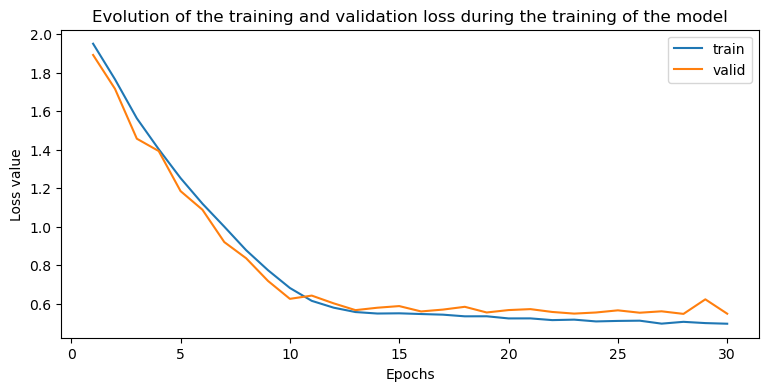

In [15]:
plt.figure(figsize=(9,4))
plt.plot(list(range(1,EPOCHS+1)), global_train_loss, label='train')
plt.plot(list(range(1,EPOCHS+1)), global_val_loss, label='valid')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Evolution of the training and validation loss during the training of the model')

##### Saving of the model weights after training

*The model's weights can be saved for later use or the pre-trained model saved can be used directly. Default directory is **Temp_out**.*


In [16]:
OUT_PATH = Path("../../Temp_out")
if not OUT_PATH.is_dir():
    OUT_PATH.mkdir()

torch.save(model.state_dict(), f'{OUT_PATH}/model_trained_{ACQUISITION_CASE}.pth')

#### Application of the trained model to test data not used for training, and computation of image quality metrics.

*Choice to use the previous model or to directly use a pretrained model already saved in github.*

In [17]:
# Load the last model saved in the 'Temp_out' directory

ud_filters, skip_filters = [32,64,128], [8,16,32]
n_scale = len(ud_filters)
model = model_unet(input_shape=1,
            down_filters=ud_filters, up_filters=ud_filters, skip_filters=skip_filters,
            down_kernels=[3]*len(ud_filters), up_kernels=[3]*len(ud_filters), skip_kernels=[1]*len(ud_filters),
            up_mode='bilinear', down_mode='stride', pad_mode='reflect'
           ).to('cuda').type(dtype)

model.load_state_dict(torch.load(f'../../Temp_out/model_trained_{ACQUISITION_CASE}.pth'))

/tmp/ipykernel_1507725/841353996.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../../Temp_out/model_trained_{ACQUISITION_CASE}.pth'

<All keys matched successfully>

In [18]:
# Application of the trained model to each of the test data

test_reco_list = []
for test_data, _ in test_dataloader:
    out_test = model(test_data)
    test_reco_list.append(simplify(out_test))

Text(0.5, 1.0, 'SIRT reference reconstruction')

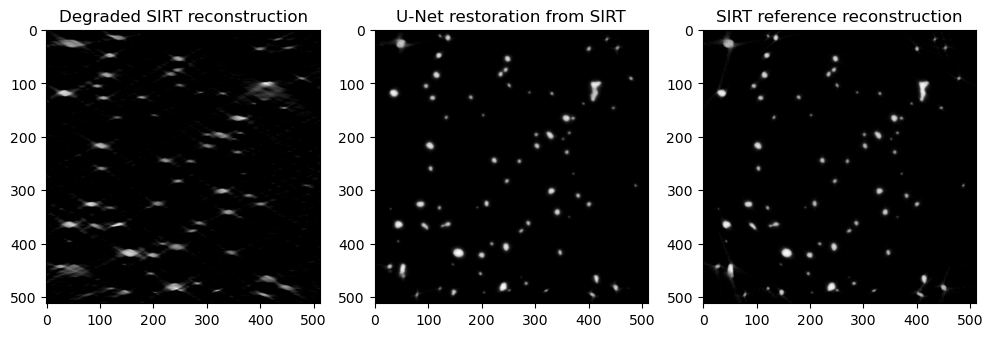

In [19]:
# Chose image index in [0 - 50] from the test data set
data_index = 15

fig, ((ax0, ax1, ax2)) = plt.subplots(1, 3, figsize = (12,8))
ax0.imshow(simplify(deg_test[data_index,:,:]))
ax0.set_title('Degraded SIRT reconstruction')
ax1.imshow(simplify(test_reco_list[data_index]))
ax1.set_title('U-Net restoration from SIRT')
ax2.imshow(simplify(ref_test[data_index]))
ax2.set_title('SIRT reference reconstruction')

In [20]:
# Computation of image quality metrics on the SIRT reconstruction and the restored images

ref = to8bit(ref_test[data_index])
sirt = to8bit(deg_test[data_index,:,:])
unet = to8bit(test_reco_list[data_index])

ssim_sirt = ssim(ref, sirt)
psnr_sirt = psnr(ref, sirt)
ssim_unet = ssim(ref, unet)
psnr_unet = psnr(ref, unet)

print('Degraded SIRT')
print(f'SSIM: {ssim_sirt:.4f} - PSNR: {psnr_sirt:.4f}')
print('Restored')
print(f'SSIM: {ssim_unet:.4f} - PSNR: {psnr_unet:.4f}')

Degraded SIRT
SSIM: 0.7490 - PSNR: 24.3880
Restored
SSIM: 0.9585 - PSNR: 36.2057
